# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [3]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

## Notebook Preferences

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [5]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [9]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

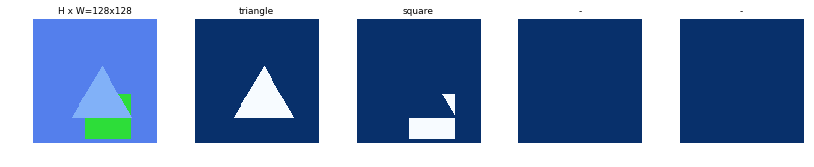

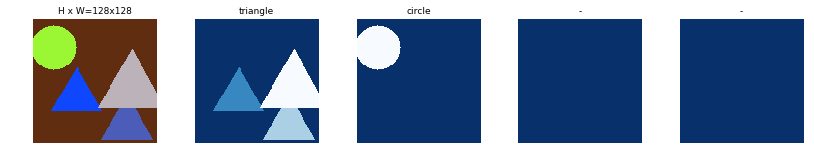

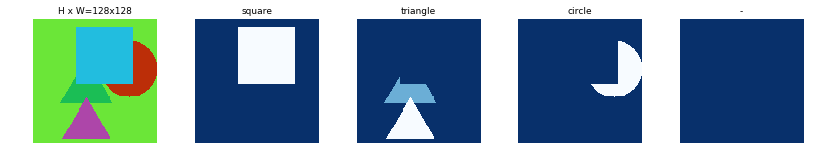

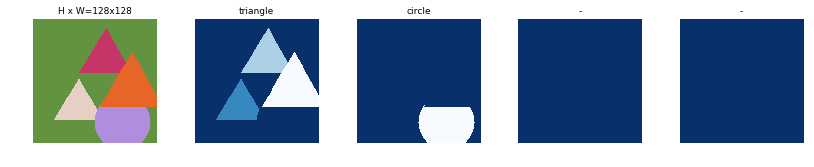

In [14]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [15]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [16]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [17]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\Simon-Mobil\Dev\Mask_RCNN\logs\shapes20180726T1525\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

c:\users\simon-mobil\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  1/100 [..............................] - ETA: 33:18 - loss: 6.1915 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 1.9636 - mrcnn_class_loss: 1.1042 - mrcnn_bbox_loss: 1.4118 - mrcnn_mask_loss: 1.6760

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  2/100 [..............................] - ETA: 23:09 - loss: 5.8701 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.9220 - mrcnn_class_loss: 0.9941 - mrcnn_bbox_loss: 1.4399 - mrcnn_mask_loss: 1.4461

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  3/100 [..............................] - ETA: 19:47 - loss: 5.7822 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.9169 - mrcnn_class_loss: 1.0017 - mrcnn_bbox_loss: 1.4401 - mrcnn_mask_loss: 1.3429

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  4/100 [>.............................] - ETA: 18:06 - loss: 5.5175 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.7819 - mrcnn_class_loss: 0.9275 - mrcnn_bbox_loss: 1.4237 - mrcnn_mask_loss: 1.3006

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/100 [>.............................] - ETA: 16:59 - loss: 5.3729 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.7516 - mrcnn_class_loss: 0.8925 - mrcnn_bbox_loss: 1.3922 - mrcnn_mask_loss: 1.2523

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/100 [>.............................] - ETA: 16:15 - loss: 5.1637 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 1.6057 - mrcnn_class_loss: 0.9227 - mrcnn_bbox_loss: 1.3538 - mrcnn_mask_loss: 1.1885

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/100 [=>............................] - ETA: 15:36 - loss: 4.9733 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 1.5252 - mrcnn_class_loss: 0.9119 - mrcnn_bbox_loss: 1.3183 - mrcnn_mask_loss: 1.1259

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/100 [=>............................] - ETA: 15:07 - loss: 4.8633 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 1.5776 - mrcnn_class_loss: 0.8506 - mrcnn_bbox_loss: 1.2590 - mrcnn_mask_loss: 1.0862

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/100 [=>............................] - ETA: 14:45 - loss: 4.6491 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.5073 - mrcnn_class_loss: 0.7996 - mrcnn_bbox_loss: 1.2102 - mrcnn_mask_loss: 1.0438

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/100 [==>...........................] - ETA: 14:23 - loss: 4.4702 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.4036 - mrcnn_class_loss: 0.7554 - mrcnn_bbox_loss: 1.2116 - mrcnn_mask_loss: 1.0155

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/100 [==>...........................] - ETA: 14:05 - loss: 4.4326 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.4417 - mrcnn_class_loss: 0.7230 - mrcnn_bbox_loss: 1.2045 - mrcnn_mask_loss: 0.9848

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/100 [==>...........................] - ETA: 13:46 - loss: 4.3749 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.4494 - mrcnn_class_loss: 0.7112 - mrcnn_bbox_loss: 1.1792 - mrcnn_mask_loss: 0.9567

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 13/100 [==>...........................] - ETA: 13:31 - loss: 4.2469 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.3920 - mrcnn_class_loss: 0.6823 - mrcnn_bbox_loss: 1.1654 - mrcnn_mask_loss: 0.9298

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/100 [===>..........................] - ETA: 13:18 - loss: 4.1674 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.3509 - mrcnn_class_loss: 0.6746 - mrcnn_bbox_loss: 1.1511 - mrcnn_mask_loss: 0.9143

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/100 [===>..........................] - ETA: 13:05 - loss: 4.0523 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.3012 - mrcnn_class_loss: 0.6395 - mrcnn_bbox_loss: 1.1458 - mrcnn_mask_loss: 0.8915

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/100 [===>..........................] - ETA: 12:52 - loss: 4.0096 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.2964 - mrcnn_class_loss: 0.6396 - mrcnn_bbox_loss: 1.1198 - mrcnn_mask_loss: 0.8777

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/100 [====>.........................] - ETA: 12:44 - loss: 3.9227 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.2658 - mrcnn_class_loss: 0.6245 - mrcnn_bbox_loss: 1.0990 - mrcnn_mask_loss: 0.8600

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/100 [====>.........................] - ETA: 12:31 - loss: 3.8274 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 1.2274 - mrcnn_class_loss: 0.6002 - mrcnn_bbox_loss: 1.0791 - mrcnn_mask_loss: 0.8490

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/100 [====>.........................] - ETA: 12:19 - loss: 3.7296 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.1957 - mrcnn_class_loss: 0.5796 - mrcnn_bbox_loss: 1.0476 - mrcnn_mask_loss: 0.8358

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/100 [=====>........................] - ETA: 12:07 - loss: 3.6309 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.1499 - mrcnn_class_loss: 0.5634 - mrcnn_bbox_loss: 1.0258 - mrcnn_mask_loss: 0.8234

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/100 [=====>........................] - ETA: 11:55 - loss: 3.5814 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.1279 - mrcnn_class_loss: 0.5547 - mrcnn_bbox_loss: 1.0165 - mrcnn_mask_loss: 0.8145

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/100 [=====>........................] - ETA: 11:45 - loss: 3.5541 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.1238 - mrcnn_class_loss: 0.5584 - mrcnn_bbox_loss: 0.9991 - mrcnn_mask_loss: 0.8047

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/100 [=====>........................] - ETA: 11:35 - loss: 3.5553 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.1272 - mrcnn_class_loss: 0.5754 - mrcnn_bbox_loss: 0.9893 - mrcnn_mask_loss: 0.7952

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/100 [======>.......................] - ETA: 11:27 - loss: 3.5121 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.1088 - mrcnn_class_loss: 0.5698 - mrcnn_bbox_loss: 0.9819 - mrcnn_mask_loss: 0.7839

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/100 [======>.......................] - ETA: 11:18 - loss: 3.4646 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.0871 - mrcnn_class_loss: 0.5690 - mrcnn_bbox_loss: 0.9667 - mrcnn_mask_loss: 0.7723

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/100 [======>.......................] - ETA: 11:09 - loss: 3.4143 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.0673 - mrcnn_class_loss: 0.5621 - mrcnn_bbox_loss: 0.9522 - mrcnn_mask_loss: 0.7631

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/100 [=======>......................] - ETA: 11:01 - loss: 3.3582 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.0493 - mrcnn_class_loss: 0.5477 - mrcnn_bbox_loss: 0.9378 - mrcnn_mask_loss: 0.7551

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/100 [=======>......................] - ETA: 10:52 - loss: 3.2928 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.0192 - mrcnn_class_loss: 0.5401 - mrcnn_bbox_loss: 0.9201 - mrcnn_mask_loss: 0.7470

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/100 [=======>......................] - ETA: 10:43 - loss: 3.2508 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.0007 - mrcnn_class_loss: 0.5384 - mrcnn_bbox_loss: 0.9058 - mrcnn_mask_loss: 0.7402

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/100 [========>.....................] - ETA: 10:34 - loss: 3.2021 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 0.9771 - mrcnn_class_loss: 0.5339 - mrcnn_bbox_loss: 0.8934 - mrcnn_mask_loss: 0.7329

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/100 [========>.....................] - ETA: 10:23 - loss: 3.1842 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 0.9840 - mrcnn_class_loss: 0.5268 - mrcnn_bbox_loss: 0.8815 - mrcnn_mask_loss: 0.7258

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/100 [========>.....................] - ETA: 10:13 - loss: 3.1347 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 0.9583 - mrcnn_class_loss: 0.5167 - mrcnn_bbox_loss: 0.8775 - mrcnn_mask_loss: 0.7177

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/100 [========>.....................] - ETA: 10:03 - loss: 3.1025 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 0.9465 - mrcnn_class_loss: 0.5111 - mrcnn_bbox_loss: 0.8692 - mrcnn_mask_loss: 0.7112

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/100 [=========>....................] - ETA: 9:53 - loss: 3.0759 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.9385 - mrcnn_class_loss: 0.5093 - mrcnn_bbox_loss: 0.8590 - mrcnn_mask_loss: 0.7048 

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/100 [=========>....................] - ETA: 9:44 - loss: 3.0254 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 0.9208 - mrcnn_class_loss: 0.5019 - mrcnn_bbox_loss: 0.8432 - mrcnn_mask_loss: 0.6967

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/100 [=========>....................] - ETA: 9:36 - loss: 2.9947 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.9166 - mrcnn_class_loss: 0.4921 - mrcnn_bbox_loss: 0.8380 - mrcnn_mask_loss: 0.6860

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/100 [==========>...................] - ETA: 9:29 - loss: 2.9709 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.9152 - mrcnn_class_loss: 0.4869 - mrcnn_bbox_loss: 0.8310 - mrcnn_mask_loss: 0.6763

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/100 [==========>...................] - ETA: 9:21 - loss: 2.9376 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.9056 - mrcnn_class_loss: 0.4834 - mrcnn_bbox_loss: 0.8205 - mrcnn_mask_loss: 0.6674

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 39/100 [==========>...................] - ETA: 9:12 - loss: 2.8989 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.8912 - mrcnn_class_loss: 0.4792 - mrcnn_bbox_loss: 0.8101 - mrcnn_mask_loss: 0.6585

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/100 [===========>..................] - ETA: 9:04 - loss: 2.9010 - rpn_class_loss: 0.0603 - rpn_bbox_loss: 0.9079 - mrcnn_class_loss: 0.4736 - mrcnn_bbox_loss: 0.8054 - mrcnn_mask_loss: 0.6537

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/100 [===========>..................] - ETA: 8:56 - loss: 2.8740 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.8989 - mrcnn_class_loss: 0.4708 - mrcnn_bbox_loss: 0.7965 - mrcnn_mask_loss: 0.6475

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/100 [===========>..................] - ETA: 8:48 - loss: 2.8616 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 0.8956 - mrcnn_class_loss: 0.4759 - mrcnn_bbox_loss: 0.7885 - mrcnn_mask_loss: 0.6412

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/100 [===========>..................] - ETA: 8:39 - loss: 2.8318 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 0.8839 - mrcnn_class_loss: 0.4726 - mrcnn_bbox_loss: 0.7808 - mrcnn_mask_loss: 0.6352

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 8:31 - loss: 2.8014 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.8728 - mrcnn_class_loss: 0.4642 - mrcnn_bbox_loss: 0.7763 - mrcnn_mask_loss: 0.6296

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/100 [============>.................] - ETA: 8:22 - loss: 2.7798 - rpn_class_loss: 0.0578 - rpn_bbox_loss: 0.8727 - mrcnn_class_loss: 0.4601 - mrcnn_bbox_loss: 0.7674 - mrcnn_mask_loss: 0.6218

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/100 [============>.................] - ETA: 8:15 - loss: 2.7632 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.8703 - mrcnn_class_loss: 0.4591 - mrcnn_bbox_loss: 0.7605 - mrcnn_mask_loss: 0.6157

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/100 [=============>................] - ETA: 8:06 - loss: 2.7399 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.8608 - mrcnn_class_loss: 0.4599 - mrcnn_bbox_loss: 0.7533 - mrcnn_mask_loss: 0.6088

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/100 [=============>................] - ETA: 7:58 - loss: 2.7133 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 0.8543 - mrcnn_class_loss: 0.4553 - mrcnn_bbox_loss: 0.7450 - mrcnn_mask_loss: 0.6022

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/100 [=============>................] - ETA: 7:48 - loss: 2.6847 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 0.8456 - mrcnn_class_loss: 0.4530 - mrcnn_bbox_loss: 0.7356 - mrcnn_mask_loss: 0.5947

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/100 [==============>...............] - ETA: 7:38 - loss: 2.6572 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.8337 - mrcnn_class_loss: 0.4510 - mrcnn_bbox_loss: 0.7275 - mrcnn_mask_loss: 0.5900

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/100 [==============>...............] - ETA: 7:29 - loss: 2.6369 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.8319 - mrcnn_class_loss: 0.4488 - mrcnn_bbox_loss: 0.7183 - mrcnn_mask_loss: 0.5833

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/100 [==============>...............] - ETA: 7:20 - loss: 2.6185 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 0.8260 - mrcnn_class_loss: 0.4478 - mrcnn_bbox_loss: 0.7121 - mrcnn_mask_loss: 0.5788

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/100 [==============>...............] - ETA: 7:11 - loss: 2.5945 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.8223 - mrcnn_class_loss: 0.4424 - mrcnn_bbox_loss: 0.7046 - mrcnn_mask_loss: 0.5721

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/100 [===============>..............] - ETA: 7:02 - loss: 2.5801 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 0.8239 - mrcnn_class_loss: 0.4380 - mrcnn_bbox_loss: 0.7006 - mrcnn_mask_loss: 0.5651

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 55/100 [===============>..............] - ETA: 6:52 - loss: 2.5662 - rpn_class_loss: 0.0521 - rpn_bbox_loss: 0.8226 - mrcnn_class_loss: 0.4367 - mrcnn_bbox_loss: 0.6943 - mrcnn_mask_loss: 0.5605

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/100 [===============>..............] - ETA: 6:42 - loss: 2.5541 - rpn_class_loss: 0.0516 - rpn_bbox_loss: 0.8187 - mrcnn_class_loss: 0.4391 - mrcnn_bbox_loss: 0.6882 - mrcnn_mask_loss: 0.5565

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/100 [================>.............] - ETA: 6:33 - loss: 2.5410 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 0.8185 - mrcnn_class_loss: 0.4371 - mrcnn_bbox_loss: 0.6832 - mrcnn_mask_loss: 0.5512

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/100 [================>.............] - ETA: 6:24 - loss: 2.5252 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.8174 - mrcnn_class_loss: 0.4343 - mrcnn_bbox_loss: 0.6774 - mrcnn_mask_loss: 0.5458

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/100 [================>.............] - ETA: 6:14 - loss: 2.5169 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.8149 - mrcnn_class_loss: 0.4352 - mrcnn_bbox_loss: 0.6741 - mrcnn_mask_loss: 0.5426

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/100 [=================>............] - ETA: 6:05 - loss: 2.5032 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.8134 - mrcnn_class_loss: 0.4332 - mrcnn_bbox_loss: 0.6693 - mrcnn_mask_loss: 0.5374

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/100 [=================>............] - ETA: 5:55 - loss: 2.4921 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.8122 - mrcnn_class_loss: 0.4335 - mrcnn_bbox_loss: 0.6643 - mrcnn_mask_loss: 0.5326

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/100 [=================>............] - ETA: 5:46 - loss: 2.4735 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.8066 - mrcnn_class_loss: 0.4323 - mrcnn_bbox_loss: 0.6582 - mrcnn_mask_loss: 0.5274

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/100 [=================>............] - ETA: 5:36 - loss: 2.4613 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.8010 - mrcnn_class_loss: 0.4313 - mrcnn_bbox_loss: 0.6554 - mrcnn_mask_loss: 0.5251

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/100 [==================>...........] - ETA: 5:27 - loss: 2.4462 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.7975 - mrcnn_class_loss: 0.4287 - mrcnn_bbox_loss: 0.6516 - mrcnn_mask_loss: 0.5199

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/100 [==================>...........] - ETA: 5:17 - loss: 2.4306 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.7917 - mrcnn_class_loss: 0.4289 - mrcnn_bbox_loss: 0.6458 - mrcnn_mask_loss: 0.5162

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 66/100 [==================>...........] - ETA: 5:08 - loss: 2.4205 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.7889 - mrcnn_class_loss: 0.4281 - mrcnn_bbox_loss: 0.6425 - mrcnn_mask_loss: 0.5132

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/100 [===================>..........] - ETA: 4:59 - loss: 2.4122 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.7840 - mrcnn_class_loss: 0.4301 - mrcnn_bbox_loss: 0.6406 - mrcnn_mask_loss: 0.5101

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/100 [===================>..........] - ETA: 4:50 - loss: 2.3963 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.7839 - mrcnn_class_loss: 0.4255 - mrcnn_bbox_loss: 0.6348 - mrcnn_mask_loss: 0.5051

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/100 [===================>..........] - ETA: 4:41 - loss: 2.3804 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.7793 - mrcnn_class_loss: 0.4239 - mrcnn_bbox_loss: 0.6301 - mrcnn_mask_loss: 0.5005

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 4:32 - loss: 2.3632 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.7741 - mrcnn_class_loss: 0.4213 - mrcnn_bbox_loss: 0.6253 - mrcnn_mask_loss: 0.4964

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/100 [====================>.........] - ETA: 4:23 - loss: 2.3488 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.7706 - mrcnn_class_loss: 0.4202 - mrcnn_bbox_loss: 0.6209 - mrcnn_mask_loss: 0.4915

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/100 [====================>.........] - ETA: 4:13 - loss: 2.3273 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.7641 - mrcnn_class_loss: 0.4167 - mrcnn_bbox_loss: 0.6151 - mrcnn_mask_loss: 0.4864

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/100 [====================>.........] - ETA: 4:04 - loss: 2.3189 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.7624 - mrcnn_class_loss: 0.4152 - mrcnn_bbox_loss: 0.6136 - mrcnn_mask_loss: 0.4831

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/100 [=====================>........] - ETA: 3:55 - loss: 2.3037 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.7566 - mrcnn_class_loss: 0.4140 - mrcnn_bbox_loss: 0.6094 - mrcnn_mask_loss: 0.4793

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/100 [=====================>........] - ETA: 3:46 - loss: 2.2891 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.7522 - mrcnn_class_loss: 0.4135 - mrcnn_bbox_loss: 0.6043 - mrcnn_mask_loss: 0.4751

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 76/100 [=====================>........] - ETA: 3:36 - loss: 2.2780 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.7531 - mrcnn_class_loss: 0.4105 - mrcnn_bbox_loss: 0.6000 - mrcnn_mask_loss: 0.4707

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/100 [======================>.......] - ETA: 3:27 - loss: 2.2695 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.7500 - mrcnn_class_loss: 0.4097 - mrcnn_bbox_loss: 0.5975 - mrcnn_mask_loss: 0.4687

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/100 [======================>.......] - ETA: 3:18 - loss: 2.2600 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.7522 - mrcnn_class_loss: 0.4073 - mrcnn_bbox_loss: 0.5926 - mrcnn_mask_loss: 0.4644

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/100 [======================>.......] - ETA: 3:09 - loss: 2.2427 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.7472 - mrcnn_class_loss: 0.4043 - mrcnn_bbox_loss: 0.5880 - mrcnn_mask_loss: 0.4601

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/100 [=======================>......] - ETA: 3:00 - loss: 2.2291 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.7419 - mrcnn_class_loss: 0.4019 - mrcnn_bbox_loss: 0.5862 - mrcnn_mask_loss: 0.4564

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/100 [=======================>......] - ETA: 2:51 - loss: 2.2163 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.7403 - mrcnn_class_loss: 0.3999 - mrcnn_bbox_loss: 0.5815 - mrcnn_mask_loss: 0.4522

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/100 [=======================>......] - ETA: 2:41 - loss: 2.2012 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7345 - mrcnn_class_loss: 0.3975 - mrcnn_bbox_loss: 0.5782 - mrcnn_mask_loss: 0.4488

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/100 [=======================>......] - ETA: 2:32 - loss: 2.1874 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.7312 - mrcnn_class_loss: 0.3956 - mrcnn_bbox_loss: 0.5739 - mrcnn_mask_loss: 0.4448

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/100 [========================>.....] - ETA: 2:23 - loss: 2.1828 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7285 - mrcnn_class_loss: 0.3959 - mrcnn_bbox_loss: 0.5713 - mrcnn_mask_loss: 0.4455

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/100 [========================>.....] - ETA: 2:14 - loss: 2.1738 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.7280 - mrcnn_class_loss: 0.3943 - mrcnn_bbox_loss: 0.5682 - mrcnn_mask_loss: 0.4421

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/100 [========================>.....] - ETA: 2:05 - loss: 2.1601 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.7249 - mrcnn_class_loss: 0.3915 - mrcnn_bbox_loss: 0.5646 - mrcnn_mask_loss: 0.4381

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/100 [=========================>....] - ETA: 1:56 - loss: 2.1475 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7209 - mrcnn_class_loss: 0.3893 - mrcnn_bbox_loss: 0.5620 - mrcnn_mask_loss: 0.4347

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/100 [=========================>....] - ETA: 1:47 - loss: 2.1383 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.7196 - mrcnn_class_loss: 0.3886 - mrcnn_bbox_loss: 0.5583 - mrcnn_mask_loss: 0.4314

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/100 [=========================>....] - ETA: 1:38 - loss: 2.1279 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.7143 - mrcnn_class_loss: 0.3874 - mrcnn_bbox_loss: 0.5577 - mrcnn_mask_loss: 0.4286

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/100 [==========================>...] - ETA: 1:29 - loss: 2.1201 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.7100 - mrcnn_class_loss: 0.3883 - mrcnn_bbox_loss: 0.5551 - mrcnn_mask_loss: 0.4270

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/100 [==========================>...] - ETA: 1:20 - loss: 2.1146 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.7091 - mrcnn_class_loss: 0.3860 - mrcnn_bbox_loss: 0.5543 - mrcnn_mask_loss: 0.4258

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/100 [==========================>...] - ETA: 1:11 - loss: 2.1029 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.7072 - mrcnn_class_loss: 0.3844 - mrcnn_bbox_loss: 0.5498 - mrcnn_mask_loss: 0.4224

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/100 [==========================>...] - ETA: 1:02 - loss: 2.0949 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.7064 - mrcnn_class_loss: 0.3828 - mrcnn_bbox_loss: 0.5473 - mrcnn_mask_loss: 0.4194

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/100 [===========================>..] - ETA: 53s - loss: 2.0828 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.7038 - mrcnn_class_loss: 0.3805 - mrcnn_bbox_loss: 0.5438 - mrcnn_mask_loss: 0.4160 

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/100 [===========================>..] - ETA: 44s - loss: 2.0726 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.7027 - mrcnn_class_loss: 0.3783 - mrcnn_bbox_loss: 0.5403 - mrcnn_mask_loss: 0.4130

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/100 [===========================>..] - ETA: 35s - loss: 2.0621 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.6998 - mrcnn_class_loss: 0.3769 - mrcnn_bbox_loss: 0.5369 - mrcnn_mask_loss: 0.4104

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/100 [============================>.] - ETA: 26s - loss: 2.0468 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.6932 - mrcnn_class_loss: 0.3742 - mrcnn_bbox_loss: 0.5343 - mrcnn_mask_loss: 0.4073

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/100 [============================>.] - ETA: 17s - loss: 2.0441 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.6936 - mrcnn_class_loss: 0.3755 - mrcnn_bbox_loss: 0.5310 - mrcnn_mask_loss: 0.4063

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/100 [============================>.] - ETA: 8s - loss: 2.0403 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.6932 - mrcnn_class_loss: 0.3756 - mrcnn_bbox_loss: 0.5294 - mrcnn_mask_loss: 0.4045 

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing

100/100 [==============================] - 914s 9s/step - loss: 2.0350 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6920 - mrcnn_class_loss: 0.3761 - mrcnn_bbox_loss: 0.5269 - mrcnn_mask_loss: 0.4026 - val_loss: 1.4488 - val_rpn_class_loss: 0.0185 - val_rpn_bbox_loss: 0.5365 - val_mrcnn_class_loss: 0.3790 - val_mrcnn_bbox_loss: 0.2674 - val_mrcnn_mask_loss: 0.2474


In [18]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\Simon-Mobil\Dev\Mask_RCNN\logs\shapes20180726T1525\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv

c:\users\simon-mobil\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2


c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  1/100 [..............................] - ETA: 1:04:33 - loss: 1.5641 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.7433 - mrcnn_class_loss: 0.2277 - mrcnn_bbox_loss: 0.2834 - mrcnn_mask_loss: 0.2840

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  2/100 [..............................] - ETA: 46:46 - loss: 1.5072 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5957 - mrcnn_class_loss: 0.2966 - mrcnn_bbox_loss: 0.3494 - mrcnn_mask_loss: 0.2452  

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  3/100 [..............................] - ETA: 40:20 - loss: 1.3745 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5394 - mrcnn_class_loss: 0.2797 - mrcnn_bbox_loss: 0.3390 - mrcnn_mask_loss: 0.2000

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  4/100 [>.............................] - ETA: 36:41 - loss: 1.3367 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.5212 - mrcnn_class_loss: 0.2885 - mrcnn_bbox_loss: 0.3149 - mrcnn_mask_loss: 0.1959

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  5/100 [>.............................] - ETA: 34:23 - loss: 1.3833 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.5120 - mrcnn_class_loss: 0.3214 - mrcnn_bbox_loss: 0.3199 - mrcnn_mask_loss: 0.2121

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  6/100 [>.............................] - ETA: 33:09 - loss: 1.3098 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.4749 - mrcnn_class_loss: 0.3222 - mrcnn_bbox_loss: 0.3019 - mrcnn_mask_loss: 0.1944

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  7/100 [=>............................] - ETA: 31:59 - loss: 1.2712 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.4565 - mrcnn_class_loss: 0.3063 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.1893

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  8/100 [=>............................] - ETA: 30:58 - loss: 1.1930 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.4454 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.2776 - mrcnn_mask_loss: 0.1757

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


  9/100 [=>............................] - ETA: 30:07 - loss: 1.1970 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.4658 - mrcnn_class_loss: 0.2804 - mrcnn_bbox_loss: 0.2687 - mrcnn_mask_loss: 0.1666

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 10/100 [==>...........................] - ETA: 29:17 - loss: 1.1772 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4554 - mrcnn_class_loss: 0.2841 - mrcnn_bbox_loss: 0.2587 - mrcnn_mask_loss: 0.1621

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 11/100 [==>...........................] - ETA: 28:39 - loss: 1.1547 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4361 - mrcnn_class_loss: 0.2834 - mrcnn_bbox_loss: 0.2596 - mrcnn_mask_loss: 0.1586

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 12/100 [==>...........................] - ETA: 28:07 - loss: 1.1481 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4215 - mrcnn_class_loss: 0.2872 - mrcnn_bbox_loss: 0.2623 - mrcnn_mask_loss: 0.1598

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 13/100 [==>...........................] - ETA: 27:27 - loss: 1.1551 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4226 - mrcnn_class_loss: 0.2871 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.1652

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 14/100 [===>..........................] - ETA: 26:53 - loss: 1.1731 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4371 - mrcnn_class_loss: 0.2872 - mrcnn_bbox_loss: 0.2634 - mrcnn_mask_loss: 0.1670

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 15/100 [===>..........................] - ETA: 26:20 - loss: 1.1772 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4434 - mrcnn_class_loss: 0.2886 - mrcnn_bbox_loss: 0.2620 - mrcnn_mask_loss: 0.1653

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 16/100 [===>..........................] - ETA: 25:46 - loss: 1.1490 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4377 - mrcnn_class_loss: 0.2776 - mrcnn_bbox_loss: 0.2552 - mrcnn_mask_loss: 0.1602

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 17/100 [====>.........................] - ETA: 25:16 - loss: 1.1712 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4443 - mrcnn_class_loss: 0.2791 - mrcnn_bbox_loss: 0.2648 - mrcnn_mask_loss: 0.1648

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 18/100 [====>.........................] - ETA: 24:50 - loss: 1.1625 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4367 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.2636 - mrcnn_mask_loss: 0.1622

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 19/100 [====>.........................] - ETA: 24:20 - loss: 1.1848 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4322 - mrcnn_class_loss: 0.2882 - mrcnn_bbox_loss: 0.2716 - mrcnn_mask_loss: 0.1743

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 20/100 [=====>........................] - ETA: 23:56 - loss: 1.1842 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.4337 - mrcnn_class_loss: 0.2888 - mrcnn_bbox_loss: 0.2700 - mrcnn_mask_loss: 0.1728

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 21/100 [=====>........................] - ETA: 23:32 - loss: 1.1712 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4380 - mrcnn_class_loss: 0.2818 - mrcnn_bbox_loss: 0.2621 - mrcnn_mask_loss: 0.1702

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 22/100 [=====>........................] - ETA: 23:16 - loss: 1.1791 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.4494 - mrcnn_class_loss: 0.2808 - mrcnn_bbox_loss: 0.2607 - mrcnn_mask_loss: 0.1689

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 23/100 [=====>........................] - ETA: 22:58 - loss: 1.1530 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4388 - mrcnn_class_loss: 0.2764 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.1660

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 24/100 [======>.......................] - ETA: 22:38 - loss: 1.1489 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4441 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.2488 - mrcnn_mask_loss: 0.1644

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 25/100 [======>.......................] - ETA: 22:13 - loss: 1.1634 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4543 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.1670

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 26/100 [======>.......................] - ETA: 21:51 - loss: 1.1633 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.4554 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.2510 - mrcnn_mask_loss: 0.1689

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 27/100 [=======>......................] - ETA: 21:30 - loss: 1.1566 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4573 - mrcnn_class_loss: 0.2652 - mrcnn_bbox_loss: 0.2484 - mrcnn_mask_loss: 0.1670

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 28/100 [=======>......................] - ETA: 21:09 - loss: 1.1474 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.4582 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.1667

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 29/100 [=======>......................] - ETA: 20:48 - loss: 1.1323 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.1655

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 30/100 [========>.....................] - ETA: 20:28 - loss: 1.1287 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4564 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.2378 - mrcnn_mask_loss: 0.1630

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 31/100 [========>.....................] - ETA: 20:08 - loss: 1.1351 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4603 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.2374 - mrcnn_mask_loss: 0.1640

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 32/100 [========>.....................] - ETA: 19:47 - loss: 1.1379 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4723 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.1628

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 33/100 [========>.....................] - ETA: 19:27 - loss: 1.1334 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.2484 - mrcnn_bbox_loss: 0.2328 - mrcnn_mask_loss: 0.1613

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 34/100 [=========>....................] - ETA: 19:08 - loss: 1.1212 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4674 - mrcnn_class_loss: 0.2458 - mrcnn_bbox_loss: 0.2306 - mrcnn_mask_loss: 0.1590

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 35/100 [=========>....................] - ETA: 18:49 - loss: 1.1155 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4641 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.2287 - mrcnn_mask_loss: 0.1596

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 36/100 [=========>....................] - ETA: 18:32 - loss: 1.1054 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4591 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.1591

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 37/100 [==========>...................] - ETA: 18:16 - loss: 1.1018 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.4621 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.2240 - mrcnn_mask_loss: 0.1578

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 38/100 [==========>...................] - ETA: 17:59 - loss: 1.1158 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.4657 - mrcnn_class_loss: 0.2430 - mrcnn_bbox_loss: 0.2263 - mrcnn_mask_loss: 0.1630

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 39/100 [==========>...................] - ETA: 17:41 - loss: 1.1271 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4640 - mrcnn_class_loss: 0.2502 - mrcnn_bbox_loss: 0.2285 - mrcnn_mask_loss: 0.1667

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 40/100 [===========>..................] - ETA: 17:23 - loss: 1.1205 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.2467 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.1659

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 41/100 [===========>..................] - ETA: 17:06 - loss: 1.1190 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4642 - mrcnn_class_loss: 0.2452 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.1653

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 42/100 [===========>..................] - ETA: 16:50 - loss: 1.1062 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4599 - mrcnn_class_loss: 0.2413 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.1639

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 43/100 [===========>..................] - ETA: 16:33 - loss: 1.1052 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4620 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.2223 - mrcnn_mask_loss: 0.1630

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 44/100 [============>.................] - ETA: 16:15 - loss: 1.1065 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.4608 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.1636

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 45/100 [============>.................] - ETA: 15:57 - loss: 1.1050 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4625 - mrcnn_class_loss: 0.2404 - mrcnn_bbox_loss: 0.2204 - mrcnn_mask_loss: 0.1642

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 46/100 [============>.................] - ETA: 15:40 - loss: 1.0986 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4616 - mrcnn_class_loss: 0.2378 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.1628

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 47/100 [=============>................] - ETA: 15:22 - loss: 1.0969 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4667 - mrcnn_class_loss: 0.2347 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.1613

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 48/100 [=============>................] - ETA: 15:06 - loss: 1.0941 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4690 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.2147 - mrcnn_mask_loss: 0.1605

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 49/100 [=============>................] - ETA: 14:51 - loss: 1.0894 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4660 - mrcnn_class_loss: 0.2328 - mrcnn_bbox_loss: 0.2135 - mrcnn_mask_loss: 0.1597

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 50/100 [==============>...............] - ETA: 14:33 - loss: 1.0923 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4641 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.2131 - mrcnn_mask_loss: 0.1612

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 51/100 [==============>...............] - ETA: 14:16 - loss: 1.0854 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4612 - mrcnn_class_loss: 0.2350 - mrcnn_bbox_loss: 0.2119 - mrcnn_mask_loss: 0.1601

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 52/100 [==============>...............] - ETA: 13:59 - loss: 1.0832 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4602 - mrcnn_class_loss: 0.2342 - mrcnn_bbox_loss: 0.2116 - mrcnn_mask_loss: 0.1598

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 53/100 [==============>...............] - ETA: 13:42 - loss: 1.0878 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4627 - mrcnn_class_loss: 0.2359 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.1594

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 54/100 [===============>..............] - ETA: 13:23 - loss: 1.0848 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4609 - mrcnn_class_loss: 0.2350 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.1600

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 55/100 [===============>..............] - ETA: 13:06 - loss: 1.0805 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4597 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.2111 - mrcnn_mask_loss: 0.1587

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 56/100 [===============>..............] - ETA: 12:49 - loss: 1.0759 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4604 - mrcnn_class_loss: 0.2314 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.1571

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 57/100 [================>.............] - ETA: 12:31 - loss: 1.0707 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4565 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.1560

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 58/100 [================>.............] - ETA: 12:13 - loss: 1.0658 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4540 - mrcnn_class_loss: 0.2300 - mrcnn_bbox_loss: 0.2086 - mrcnn_mask_loss: 0.1560

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 59/100 [================>.............] - ETA: 11:56 - loss: 1.0668 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4562 - mrcnn_class_loss: 0.2280 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.1554

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 60/100 [=================>............] - ETA: 11:39 - loss: 1.0625 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4565 - mrcnn_class_loss: 0.2253 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.1543

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 61/100 [=================>............] - ETA: 11:21 - loss: 1.0552 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4542 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.2087 - mrcnn_mask_loss: 0.1534

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 62/100 [=================>............] - ETA: 11:04 - loss: 1.0525 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4550 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.1522

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 63/100 [=================>............] - ETA: 10:47 - loss: 1.0487 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4534 - mrcnn_class_loss: 0.2199 - mrcnn_bbox_loss: 0.2071 - mrcnn_mask_loss: 0.1514

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 64/100 [==================>...........] - ETA: 10:30 - loss: 1.0478 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4510 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2076 - mrcnn_mask_loss: 0.1519

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 65/100 [==================>...........] - ETA: 10:12 - loss: 1.0493 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.4480 - mrcnn_class_loss: 0.2218 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.1542

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 66/100 [==================>...........] - ETA: 9:54 - loss: 1.0455 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.4470 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2079 - mrcnn_mask_loss: 0.1533 

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 67/100 [===================>..........] - ETA: 9:36 - loss: 1.0527 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4467 - mrcnn_class_loss: 0.2229 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.1570

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 68/100 [===================>..........] - ETA: 9:18 - loss: 1.0583 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4487 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.1577

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 69/100 [===================>..........] - ETA: 9:00 - loss: 1.0589 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4512 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.2101 - mrcnn_mask_loss: 0.1573

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 70/100 [====================>.........] - ETA: 8:43 - loss: 1.0527 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4507 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.2082 - mrcnn_mask_loss: 0.1561

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 71/100 [====================>.........] - ETA: 8:25 - loss: 1.0487 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4482 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.2080 - mrcnn_mask_loss: 0.1563

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 72/100 [====================>.........] - ETA: 8:08 - loss: 1.0451 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4488 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.1556

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 73/100 [====================>.........] - ETA: 7:50 - loss: 1.0456 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4508 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.1550

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 74/100 [=====================>........] - ETA: 7:33 - loss: 1.0433 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4498 - mrcnn_class_loss: 0.2148 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.1552

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 75/100 [=====================>........] - ETA: 7:15 - loss: 1.0454 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4509 - mrcnn_class_loss: 0.2143 - mrcnn_bbox_loss: 0.2072 - mrcnn_mask_loss: 0.1556

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 76/100 [=====================>........] - ETA: 6:58 - loss: 1.0388 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4477 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.2063 - mrcnn_mask_loss: 0.1548

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 77/100 [======================>.......] - ETA: 6:40 - loss: 1.0398 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4485 - mrcnn_class_loss: 0.2121 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.1556

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 78/100 [======================>.......] - ETA: 6:23 - loss: 1.0395 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4490 - mrcnn_class_loss: 0.2123 - mrcnn_bbox_loss: 0.2056 - mrcnn_mask_loss: 0.1552

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 79/100 [======================>.......] - ETA: 6:06 - loss: 1.0388 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4480 - mrcnn_class_loss: 0.2130 - mrcnn_bbox_loss: 0.2057 - mrcnn_mask_loss: 0.1548

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 80/100 [=======================>......] - ETA: 5:48 - loss: 1.0411 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4467 - mrcnn_class_loss: 0.2134 - mrcnn_bbox_loss: 0.2057 - mrcnn_mask_loss: 0.1581

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 81/100 [=======================>......] - ETA: 5:31 - loss: 1.0421 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4467 - mrcnn_class_loss: 0.2142 - mrcnn_bbox_loss: 0.2053 - mrcnn_mask_loss: 0.1588

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 82/100 [=======================>......] - ETA: 5:14 - loss: 1.0378 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4454 - mrcnn_class_loss: 0.2125 - mrcnn_bbox_loss: 0.2048 - mrcnn_mask_loss: 0.1579

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 83/100 [=======================>......] - ETA: 4:56 - loss: 1.0392 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4456 - mrcnn_class_loss: 0.2127 - mrcnn_bbox_loss: 0.2047 - mrcnn_mask_loss: 0.1590

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 84/100 [========================>.....] - ETA: 4:39 - loss: 1.0372 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4457 - mrcnn_class_loss: 0.2123 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.1585

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 85/100 [========================>.....] - ETA: 4:21 - loss: 1.0372 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.4490 - mrcnn_class_loss: 0.2105 - mrcnn_bbox_loss: 0.2027 - mrcnn_mask_loss: 0.1579

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 86/100 [========================>.....] - ETA: 4:04 - loss: 1.0354 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.4474 - mrcnn_class_loss: 0.2112 - mrcnn_bbox_loss: 0.2024 - mrcnn_mask_loss: 0.1574

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 87/100 [=========================>....] - ETA: 3:47 - loss: 1.0332 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4472 - mrcnn_class_loss: 0.2103 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.1571

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 88/100 [=========================>....] - ETA: 3:29 - loss: 1.0322 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.4488 - mrcnn_class_loss: 0.2087 - mrcnn_bbox_loss: 0.2010 - mrcnn_mask_loss: 0.1568

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 89/100 [=========================>....] - ETA: 3:12 - loss: 1.0364 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4517 - mrcnn_class_loss: 0.2100 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.1567

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 90/100 [==========================>...] - ETA: 2:55 - loss: 1.0353 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4524 - mrcnn_class_loss: 0.2089 - mrcnn_bbox_loss: 0.2002 - mrcnn_mask_loss: 0.1566

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 91/100 [==========================>...] - ETA: 2:37 - loss: 1.0343 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.4524 - mrcnn_class_loss: 0.2085 - mrcnn_bbox_loss: 0.2001 - mrcnn_mask_loss: 0.1561

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 92/100 [==========================>...] - ETA: 2:20 - loss: 1.0345 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.4522 - mrcnn_class_loss: 0.2080 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.1562

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 93/100 [==========================>...] - ETA: 2:02 - loss: 1.0319 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4516 - mrcnn_class_loss: 0.2074 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.1556

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 94/100 [===========================>..] - ETA: 1:45 - loss: 1.0321 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4496 - mrcnn_class_loss: 0.2083 - mrcnn_bbox_loss: 0.2000 - mrcnn_mask_loss: 0.1567

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 95/100 [===========================>..] - ETA: 1:27 - loss: 1.0304 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4518 - mrcnn_class_loss: 0.2064 - mrcnn_bbox_loss: 0.1989 - mrcnn_mask_loss: 0.1559

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 96/100 [===========================>..] - ETA: 1:10 - loss: 1.0336 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4509 - mrcnn_class_loss: 0.2069 - mrcnn_bbox_loss: 0.2004 - mrcnn_mask_loss: 0.1579

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 97/100 [============================>.] - ETA: 52s - loss: 1.0316 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.2070 - mrcnn_bbox_loss: 0.2005 - mrcnn_mask_loss: 0.1574 

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 98/100 [============================>.] - ETA: 35s - loss: 1.0316 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4512 - mrcnn_class_loss: 0.2064 - mrcnn_bbox_loss: 0.1995 - mrcnn_mask_loss: 0.1572

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


 99/100 [============================>.] - ETA: 17s - loss: 1.0327 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4522 - mrcnn_class_loss: 0.2065 - mrcnn_bbox_loss: 0.1998 - mrcnn_mask_loss: 0.1568

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing

100/100 [==============================] - 1807s 18s/step - loss: 1.0344 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.4515 - mrcnn_class_loss: 0.2082 - mrcnn_bbox_loss: 0.2002 - mrcnn_mask_loss: 0.1570 - val_loss: 0.8199 - val_rpn_class_loss: 0.0133 - val_rpn_bbox_loss: 0.3738 - val_mrcnn_class_loss: 0.1541 - val_mrcnn_bbox_loss: 0.1360 - val_mrcnn_mask_loss: 0.1426


In [19]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [7]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "logs\\shapes20180726T1525\\mask_rcnn_shapes_0002.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\Simon-Mobil\Dev\Mask_RCNN\logs\shapes20180726T1525\mask_rcnn_shapes_0002.h5


original_image           shape: (128, 128, 3)         min:    9.00000  max:  240.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (3,)                  min:    2.00000  max:    3.00000  int32
gt_bbox                  shape: (3, 4)                min:    2.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 3)         min:    0.00000  max:    1.00000  bool


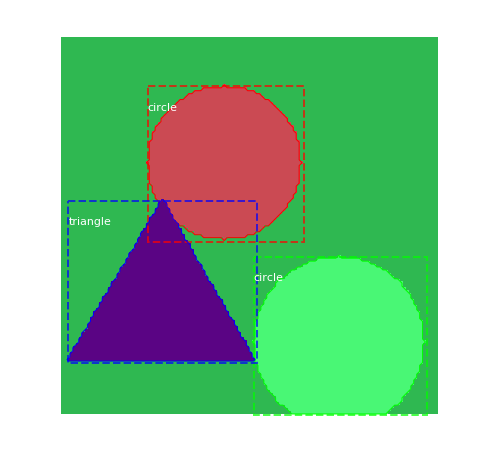

In [10]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    9.00000  max:  240.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -107.80000  max:  131.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


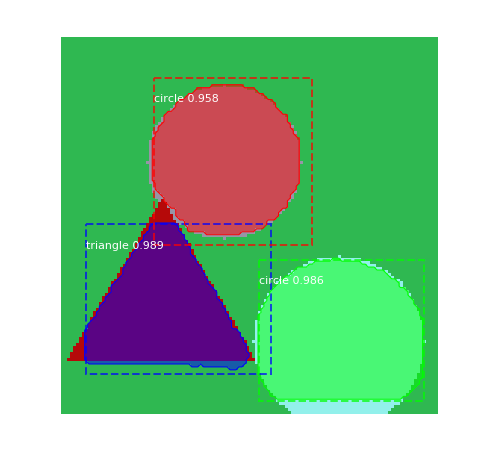

In [11]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [13]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing

c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing

mAP:  0.9455555578072865


c:\users\simon-mobil\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
